In [1]:
import pandas as pd 
import numpy as np 
from src.utils.preprocess import get_videoid

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

import yaml
with open("../../src/configs.yml", "r") as configs:
    configs = yaml.safe_load(configs)

ROOTPATH = configs["ROOTPATH"]
DATAPATH = configs["DATAPATH"]
ROOTPATH2 = configs["ROOTPATH2"]
# OUTPATH = "../../output/results-summary-071224/"
OUTPATH = "../../output/results-summary-081424/"

START = configs["START"]
END = configs["END"]
print(configs)
print(START)
print(END)

{'ROOTPATH': '/Users/yijingch/Documents/GITHUB/invisible-public/', 'ROOTPATH2': '/Users/yijingch/Documents/GITHUB/dd-full/', 'DATAPATH': '/Users/yijingch/Documents/GITHUB/dd-full/data/', 'DATAPATH2': '/Users/yijingch/Documents/GITHUB/collect-youtube-content/data/', 'INDEXPATH': '/Users/yijingch/Documents/GITHUB/dd-full/index/', 'START': datetime.datetime(2018, 5, 1, 0, 0), 'END': datetime.datetime(2023, 5, 1, 0, 0)}
2018-05-01 00:00:00
2023-05-01 00:00:00


In [2]:
view_all = pd.read_csv(DATAPATH + "youtube/yt_watch.csv", sep=";")
view_all = view_all[["respondent_id","titleUrl","channel_url", "timestamp"]].rename(columns={"titleUrl":"video_url"})
view_all["channel_id"] = view_all["channel_url"].map(lambda x: x.split("/")[-1] if str(x)!= "nan" else np.NaN)
view_all["video_id"] = view_all["video_url"].map(lambda x: get_videoid(x))
view_all = view_all.dropna(subset = ["respondent_id", "video_id", "channel_id"])[["respondent_id","channel_id","video_id","timestamp"]]

subscribe_all = pd.read_csv(DATAPATH + "youtube/yt_subscriptions.csv", sep=";")[["respondent_id","channel_id"]]

comment_all = pd.read_csv(DATAPATH + "youtube/yt_comments_from2018may_to2023may_new.csv", sep=";").rename(columns={"snippet.channelId":"channel_id"})
comment_all = comment_all[["respondent_id","video_id", "channel_id", "comments_n"]].dropna()
comment_public = pd.read_pickle(DATAPATH + "youtube/yt_comments_public_061824.pkl")
comment_public = comment_public[comment_public["author_name"]!=""]

view_all["timestamp"] = pd.to_datetime(view_all["timestamp"])
view_all = view_all[(view_all["timestamp"]>=START)&(view_all["timestamp"]<=END)].copy()

comment_public["timestamp"] = pd.to_datetime(comment_public["published_at"]).dt.tz_localize(None)
comment_public = comment_public[(comment_public["timestamp"]>=START)&(comment_public["timestamp"]<=END)].copy()
# subscribing data cannot be filtered; sample comment is already filtered

In [3]:
channel_labels_all = pd.read_excel(ROOTPATH2 + "index/yt_polclass_20240627.xlsx")
channel_labels_all

label_col = "classification_lvl1_4cat"
LABEL_MAP = {
    1: 0, # neutral 
    2: -1, # anti-gov 
    3: 1, # pro-gov
}

channel_labels = channel_labels_all[channel_labels_all[label_col].isin(LABEL_MAP.keys())]

CHANNEL_LABEL_MAP = {}
for lab,val in LABEL_MAP.items():
    channel_subdf = channel_labels[channel_labels[label_col]==lab]
    these_channels = set(channel_subdf["channel_id"].tolist())
    print(lab, val, "# of channels", len(these_channels))
    for this_ch in these_channels:
        CHANNEL_LABEL_MAP[this_ch] = {}
        CHANNEL_LABEL_MAP[this_ch]["leaning"] = val 

CHANNEL_LABEL_MAP["UCKY8HrMpm32WAMK0lauLAZA"]["leaning"] = 1
len(CHANNEL_LABEL_MAP)

1 0 # of channels 149
2 -1 # of channels 276
3 1 # of channels 139


564

In [4]:
these_channels = CHANNEL_LABEL_MAP.keys()
pol_view = view_all[view_all["channel_id"].isin(these_channels)].copy()
pol_subscribe = subscribe_all[subscribe_all["channel_id"].isin(these_channels)].copy()
pol_comment = comment_all[comment_all["channel_id"].isin(these_channels)].copy()
pol_comment_public = comment_public[comment_public["channel_id"].isin(these_channels)].copy()

## some channel-level statistics

In [5]:
comment_aggr = pol_comment.groupby("channel_id").agg({
    "comments_n":lambda x: np.sum(list(x)),
    "respondent_id":lambda x: len(set(x)),
    }).reset_index()
comment_aggr_public = pol_comment_public.groupby("channel_id").agg({
    "video_id":lambda x: len(list(x)),
    "author_name":lambda x: len(set(x)),
    }).reset_index()

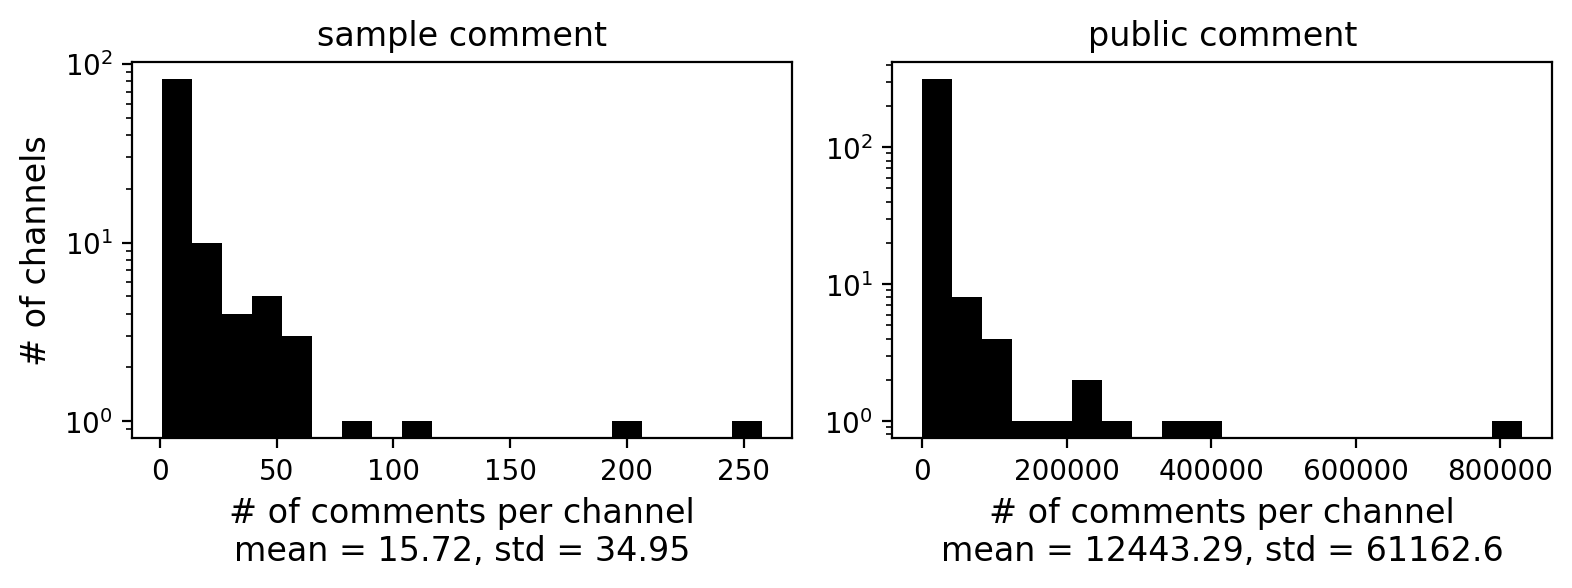

In [6]:
fig,ax = plt.subplots(ncols=2, figsize=(8,3))

for i,(df,col) in enumerate(zip(
    [comment_aggr, comment_aggr_public],
    ["comments_n", "video_id"])):
    m = np.mean(df[col])
    s = np.std(df[col])
    ax[i].hist(df[col], color="black", bins=20)
    ax[i].set_yscale("log")
    ax[i].set_xlabel(f"# of comments per channel\nmean = {round(m,2)}, std = {round(s,2)}", fontsize=12)

ax[0].set_title("sample comment", fontsize=12)
ax[1].set_title("public comment", fontsize=12)
ax[0].set_ylabel("# of channels", fontsize=12)
plt.tight_layout()
plt.show()

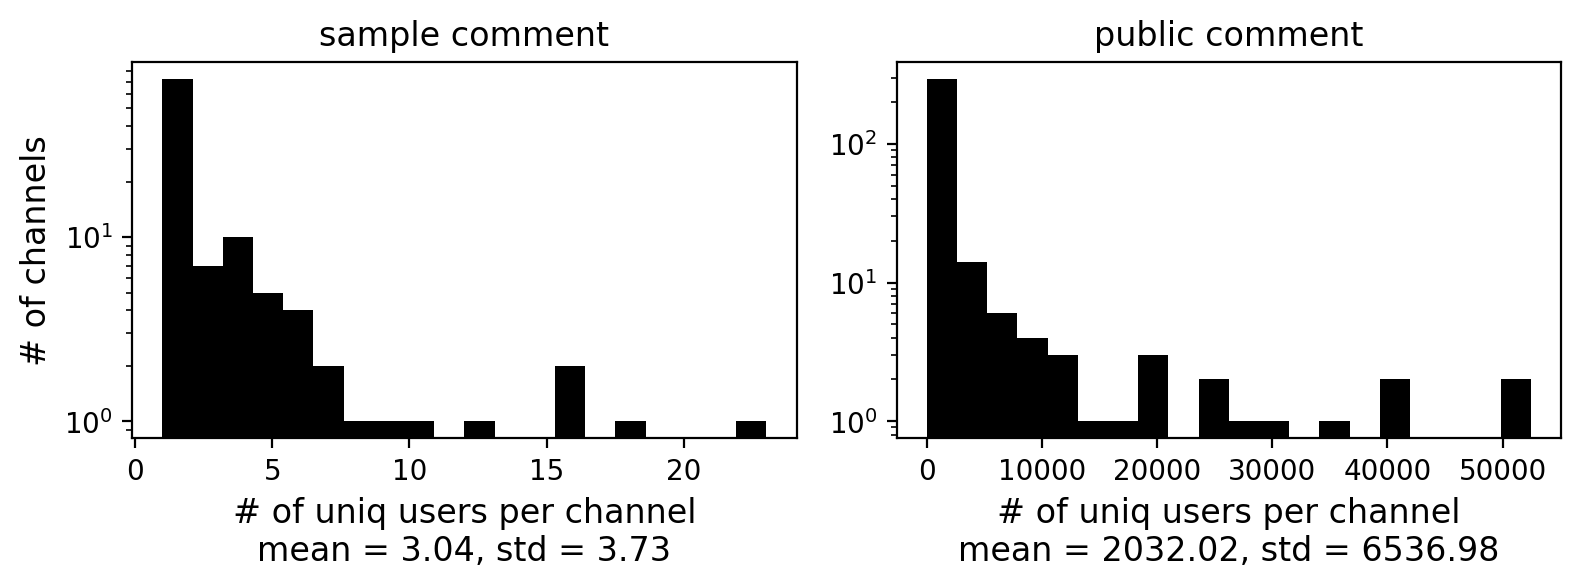

In [7]:
fig,ax = plt.subplots(ncols=2, figsize=(8,3))

for i,(df,col) in enumerate(zip(
    [comment_aggr, comment_aggr_public],
    ["respondent_id", "author_name"])):
    m = np.mean(df[col])
    s = np.std(df[col])
    ax[i].hist(df[col], color="black", bins=20)
    ax[i].set_yscale("log")
    ax[i].set_xlabel(f"# of uniq users per channel\nmean = {round(m,2)}, std = {round(s,2)}", fontsize=12)

ax[0].set_title("sample comment", fontsize=12)
ax[1].set_title("public comment", fontsize=12)
ax[0].set_ylabel("# of channels", fontsize=12)
plt.tight_layout()
plt.show()

In [8]:
comment_aggr = pol_comment.groupby("respondent_id").agg({
    "comments_n":lambda x: np.sum(list(x)),
    "channel_id":lambda x: len(set(x)),
    }).reset_index()
comment_aggr_public = pol_comment_public.groupby("author_name").agg({
    "video_id":lambda x: len(list(x)),
    "channel_id":lambda x: len(set(x)),
    }).reset_index()

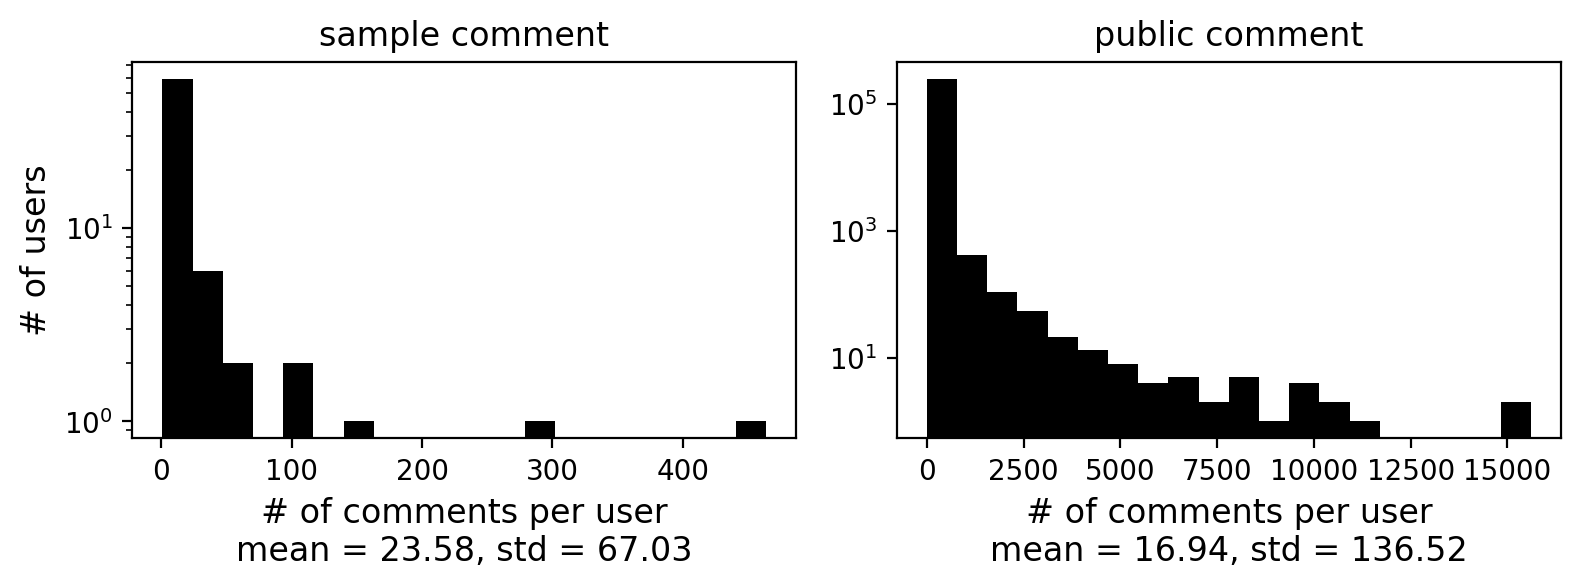

In [9]:
fig,ax = plt.subplots(ncols=2, figsize=(8,3))

for i,(df,col) in enumerate(zip(
    [comment_aggr, comment_aggr_public],
    ["comments_n", "video_id"])):
    m = np.mean(df[col])
    s = np.std(df[col])
    ax[i].hist(df[col], color="black", bins=20)
    ax[i].set_yscale("log")
    ax[i].set_xlabel(f"# of comments per user\nmean = {round(m,2)}, std = {round(s,2)}", fontsize=12)

ax[0].set_title("sample comment", fontsize=12)
ax[1].set_title("public comment", fontsize=12)
ax[0].set_ylabel("# of users", fontsize=12)
plt.tight_layout()
plt.show()

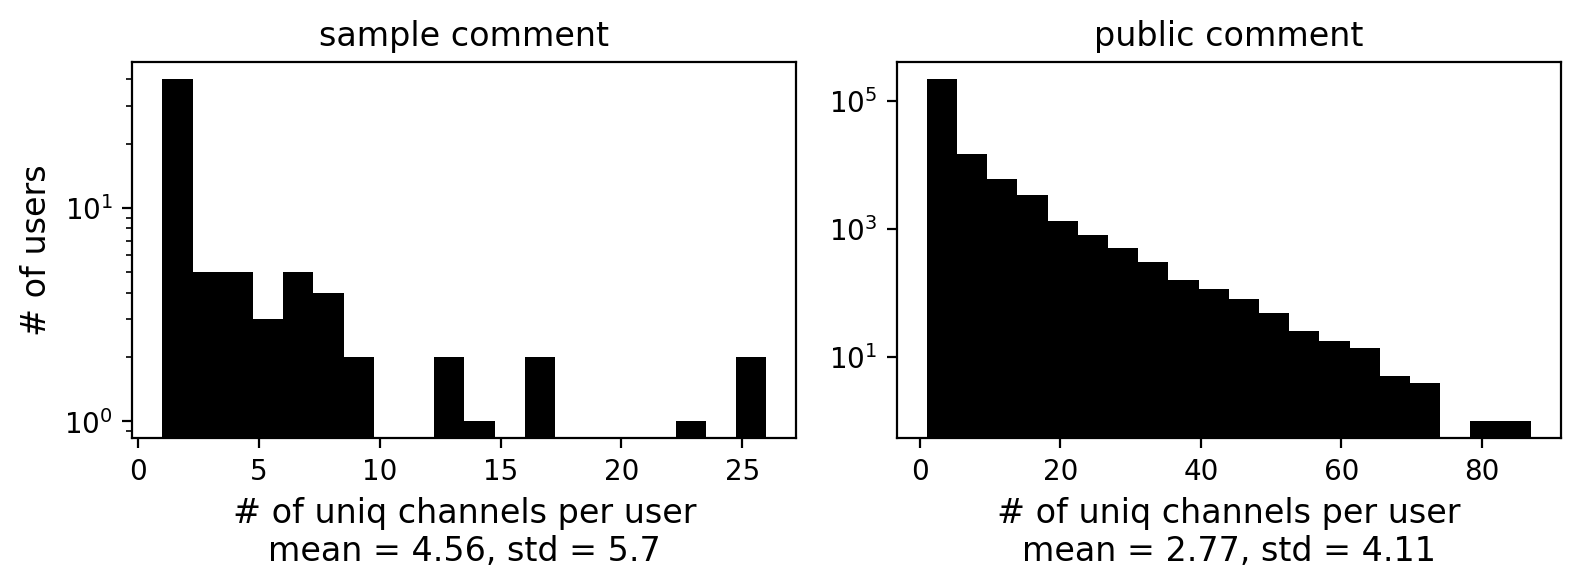

In [10]:
fig,ax = plt.subplots(ncols=2, figsize=(8,3))

for i,(df,col) in enumerate(zip(
    [comment_aggr, comment_aggr_public],
    ["channel_id", "channel_id"])):
    m = np.mean(df[col])
    s = np.std(df[col])
    ax[i].hist(df[col], color="black", bins=20)
    ax[i].set_yscale("log")
    ax[i].set_xlabel(f"# of uniq channels per user\nmean = {round(m,2)}, std = {round(s,2)}", fontsize=12)

ax[0].set_title("sample comment", fontsize=12)
ax[1].set_title("public comment", fontsize=12)
ax[0].set_ylabel("# of users", fontsize=12)
plt.tight_layout()
plt.show()

In [11]:
from src.utils.network_builder import build_projection, read_network

In [12]:
# n,e = build_projection(
#     df = pol_view, 
#     node_col = "channel_id",
#     feature_col = "respondent_id",
#     density_thres = 0,
#     node_label_map = CHANNEL_LABEL_MAP,
#     node_labels = ["leaning"],
#     print_info = True,
#     save_num_idx = True,
#     save_fpath = OUTPATH + "/view/")

# # # density 0.02
# # of nodes: 545
# # of edges: 5931

In [13]:
# n,e = build_projection(
#     df = pol_subscribe, 
#     node_col = "channel_id",
#     feature_col = "respondent_id",
#     density_thres = 0.05,
#     node_label_map = CHANNEL_LABEL_MAP,
#     node_labels = ["leaning"],
#     print_info = True,
#     save_num_idx = True,
#     save_fpath = OUTPATH + "/subscribe/")

# # density 0.05
# # of nodes: 210
# # of edges: 2195

In [14]:
# n,e = build_projection(
#     df = pol_comment, 
#     node_col = "channel_id",
#     feature_col = "respondent_id",
#     density_thres = 0.1,
#     node_label_map = CHANNEL_LABEL_MAP,
#     node_labels = ["leaning"],
#     print_info = True,
#     save_num_idx = True,
#     save_fpath = OUTPATH + "/comment/")

# # density 0.1
# # of nodes: 108
# # of edges: 1158

In [16]:
n,e = build_projection(
    df = pol_comment_public,
    node_col = "channel_id",
    feature_col = "author_name",
    density_thres = 0.03,
    node_label_map = CHANNEL_LABEL_MAP,
    node_labels = ["leaning"],
    print_info = True,
    save_num_idx = True,
    save_fpath = OUTPATH + "/comment-public/")

# this is going to take a while ~ 2.5mins

# density 0.03
# of nodes: 334
# of edges: 3338

# of nodes: 333
# of edges: 3318


In [17]:
from itertools import combinations
def get_bp_data(node_df, edge_df):
    edge_weight_map = edge_df.set_index(["Label_target", "Label_source"]).to_dict()["weight"]
    leanings = [-1, 0, 1]
    bp_data = []
    for l in leanings:
        these_nodes = node_df[node_df["leaning"]==l]["Label"].tolist()
        weights = []
        for n1, n2 in combinations(these_nodes, 2):
            try:
                w = edge_weight_map[(n1, n2)]
            except:
                w = edge_weight_map[(n2, n1)]
            weights.append(w)
        bp_data.append(weights)
    return bp_data

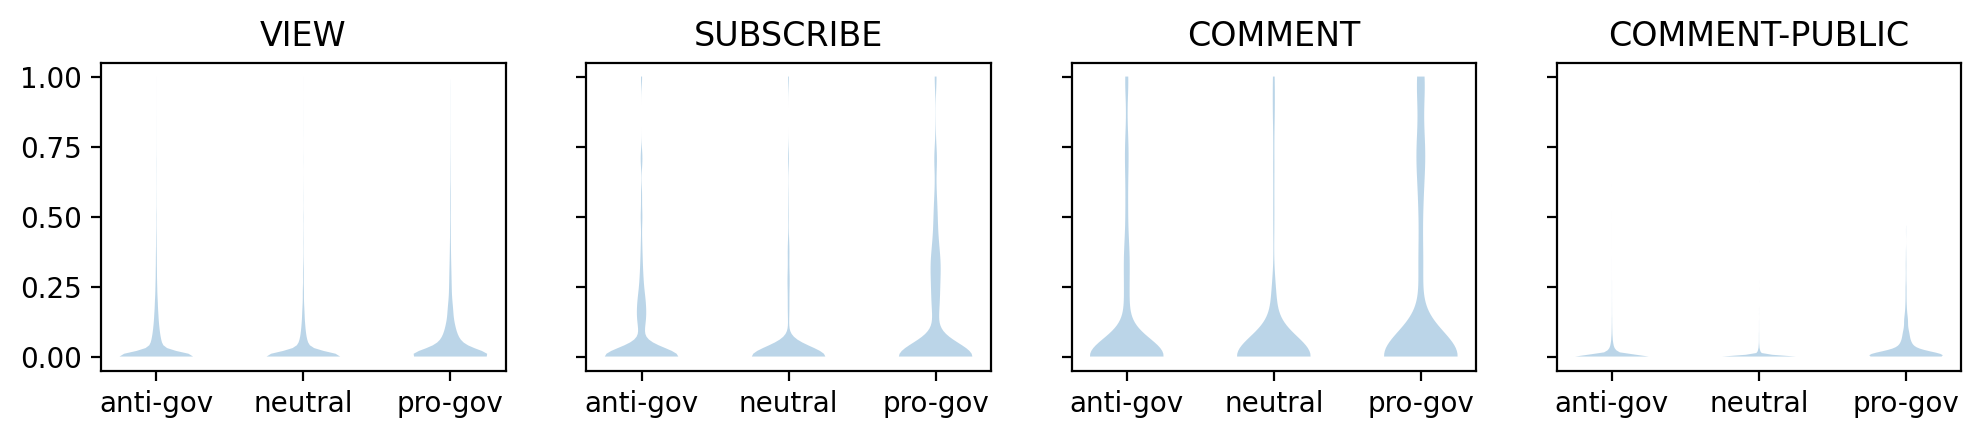

In [18]:
engage_type = ["view", "subscribe", "comment", "comment-public"]
bp_data_dict = {}
fig,ax = plt.subplots(ncols=len(engage_type), figsize=(12,2), sharey=True)
for i,this_folder in enumerate(engage_type):
    bp_data_dict[this_folder] = []
    try:
        node_df = pd.read_csv(OUTPATH + f"{this_folder}/projnet_channel_id_respondent_id_density0_NODE.csv")
        edge_df = pd.read_csv(OUTPATH + f"{this_folder}/projnet_channel_id_respondent_id_density0_EDGE.csv")
    except:
        node_df = pd.read_csv(OUTPATH + f"{this_folder}/projnet_channel_id_author_name_density0_NODE.csv")
        edge_df = pd.read_csv(OUTPATH + f"{this_folder}/projnet_channel_id_author_name_density0_EDGE.csv")
    bp_data = get_bp_data(node_df, edge_df)
    # plt.yscale("log")
    ax[i].violinplot(bp_data, showextrema=False)
    ax[i].set_title(this_folder.upper())
    ax[i].set_xticks(range(1,4), ["anti-gov", "neutral", "pro-gov"])

In [19]:
import networkx as nx 

def get_node_level_EI(g):
    
    node_attrs = nx.get_node_attributes(g, "leaning")
    node_strgs = nx.degree(g, weight="weight")
    edge_attrs = nx.get_edge_attributes(g, "weight")

    ei_df = pd.DataFrame()
    eis = []
    leanings = []
    strengths = []
    for n in g.nodes():
        n_attr = node_attrs[n]
        n_strg = node_strgs[n]
        neighbors = nx.neighbors(g, n)
        if n_strg > 0:
            internal = 0
            external = 0
            for nei in neighbors:
                try:
                    w = edge_attrs[nei, n]
                except:
                    w = edge_attrs[n, nei]
                if node_attrs[nei] == n_attr:
                    internal += w 
                else:
                    external += w
            ei = (external - internal) / (external + internal)

            eis.append(ei)
            leanings.append(n_attr)
            strengths.append(n_strg)
    
    ei_df["rate"] = eis
    ei_df["leaning"] = leanings
    ei_df["strength"] = strengths
    return ei_df

In [20]:
rate_data = {}
for i,this_folder in enumerate(engage_type):
    bp_data_dict[this_folder] = []
    try:
        node_df = pd.read_csv(OUTPATH + f"{this_folder}/projnet_channel_id_respondent_id_density0_NODE.csv")
        edge_df = pd.read_csv(OUTPATH + f"{this_folder}/projnet_channel_id_respondent_id_density0_EDGE.csv")
    except:
        node_df = pd.read_csv(OUTPATH + f"{this_folder}/projnet_channel_id_author_name_density0_NODE.csv")
        edge_df = pd.read_csv(OUTPATH + f"{this_folder}/projnet_channel_id_author_name_density0_EDGE.csv")
    g = read_network(node_df, edge_df, add_node_attrs=True, add_edge_attrs=True)
    rates_df = get_node_level_EI(g)
    rate_data[this_folder] = rates_df

Graph with 545 nodes and 148240 edges
Graph with 210 nodes and 21945 edges
Graph with 108 nodes and 5778 edges
Graph with 333 nodes and 55278 edges


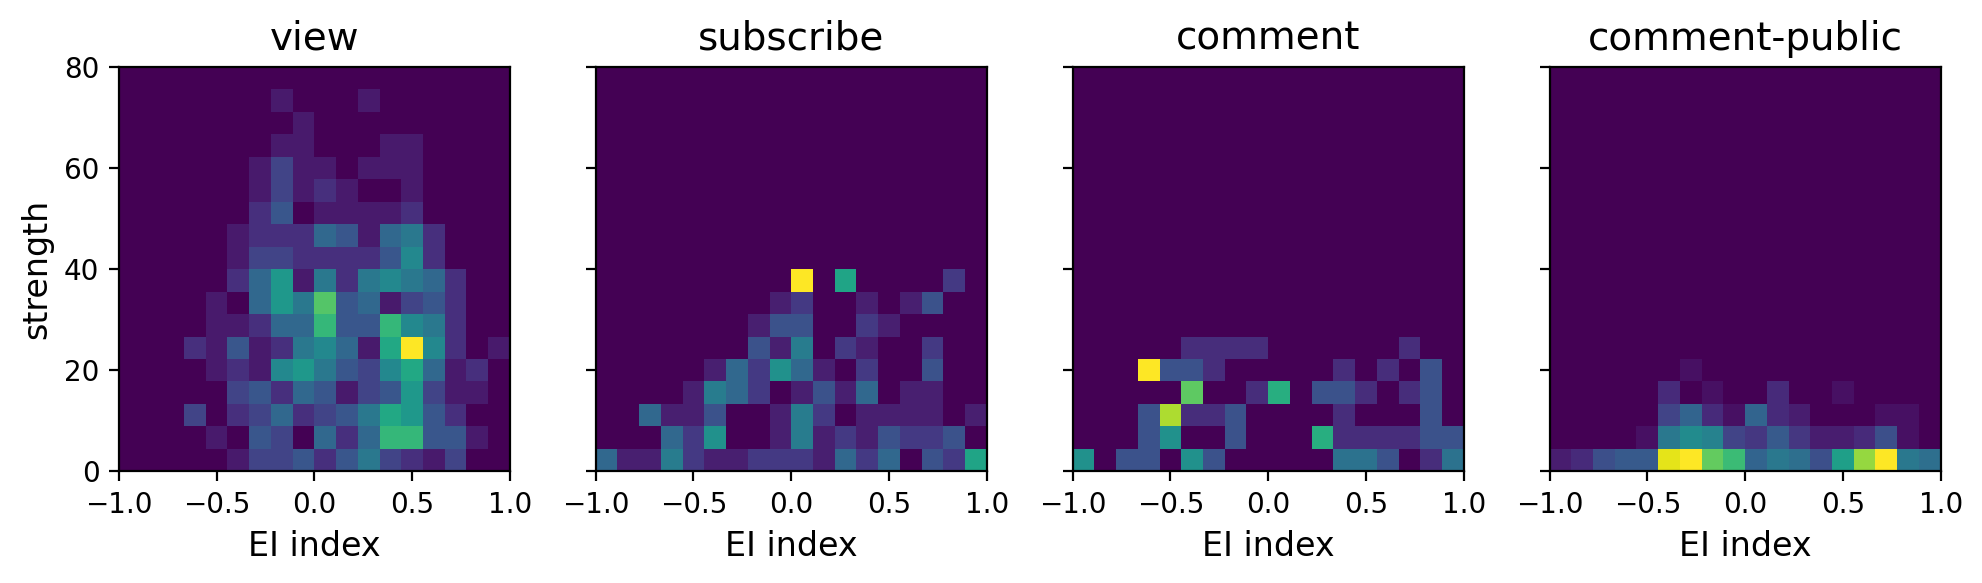

In [21]:
fig,ax = plt.subplots(ncols=4, figsize=(10,3), sharey=True)
for i,this_folder in enumerate(engage_type):
    rate_df = rate_data[this_folder]
    # ax[i].scatter(rate_df["rate"], rate_df["strength"], color="black")
    ax[i].hist2d(rate_df["rate"], rate_df["strength"], bins=18, range=np.array([(-1, 1), (0, 80)]))
    ax[i].set_xlim(-1,1)
    ax[i].set_xlabel("EI index", fontsize=12)
    ax[i].set_title(this_folder, fontsize=14)
ax[0].set_ylabel("strength", fontsize=12)
plt.tight_layout()

view
average EI: 0.19086906727012487
subscribe
average EI: 0.0801274313037519
comment
average EI: -0.029814493969159875
comment-public
average EI: 0.07358305054109221


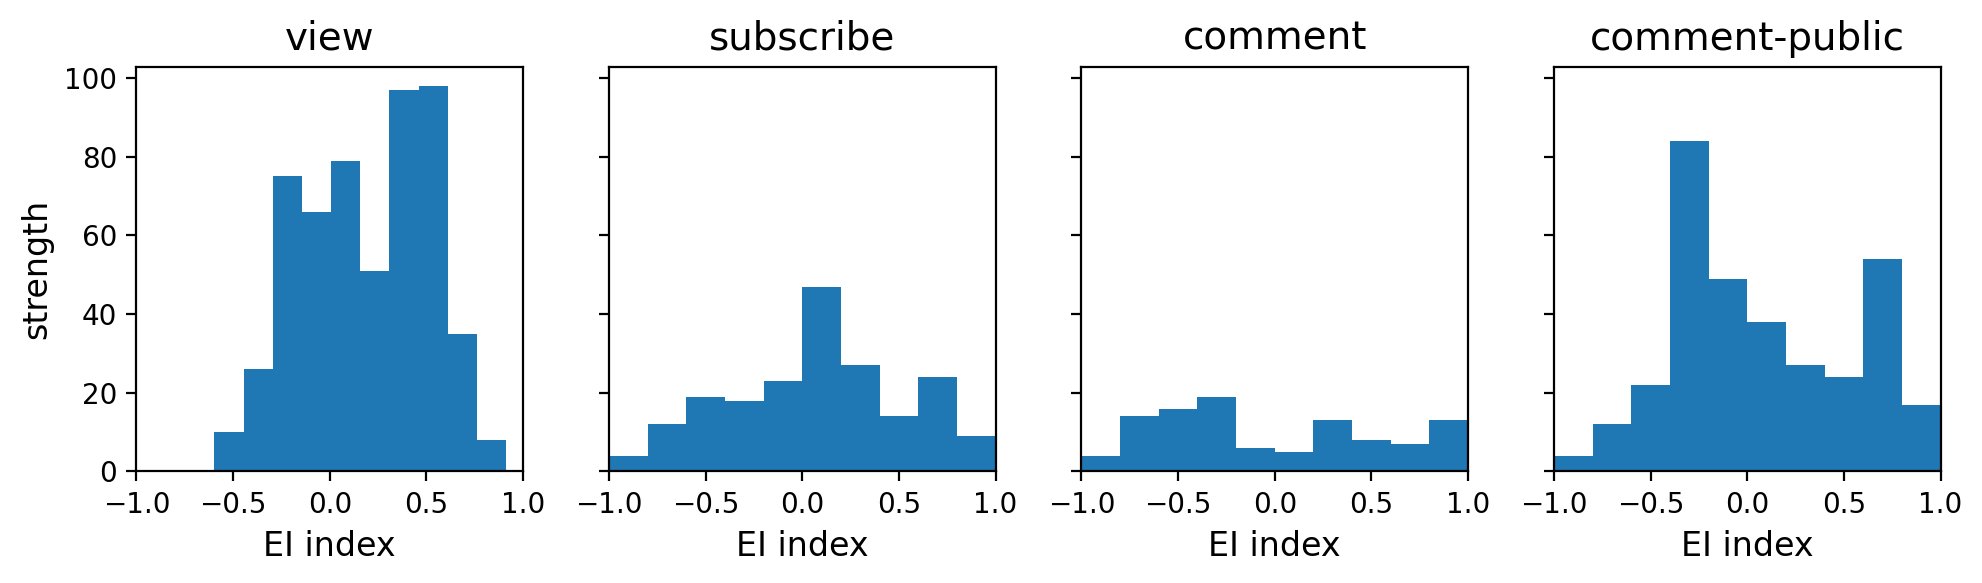

In [22]:
fig,ax = plt.subplots(ncols=4, figsize=(10,3), sharey=True)
for i,this_folder in enumerate(engage_type):
    rate_df = rate_data[this_folder]
    # ax[i].scatter(rate_df["rate"], rate_df["strength"], color="black")
    ax[i].hist(rate_df["rate"])
    ax[i].set_xlim(-1,1)
    ax[i].set_xlabel("EI index", fontsize=12)
    ax[i].set_title(this_folder, fontsize=14)
    print(this_folder)
    print("average EI:", np.mean(rate_df["rate"]))
ax[0].set_ylabel("strength", fontsize=12)
plt.tight_layout()

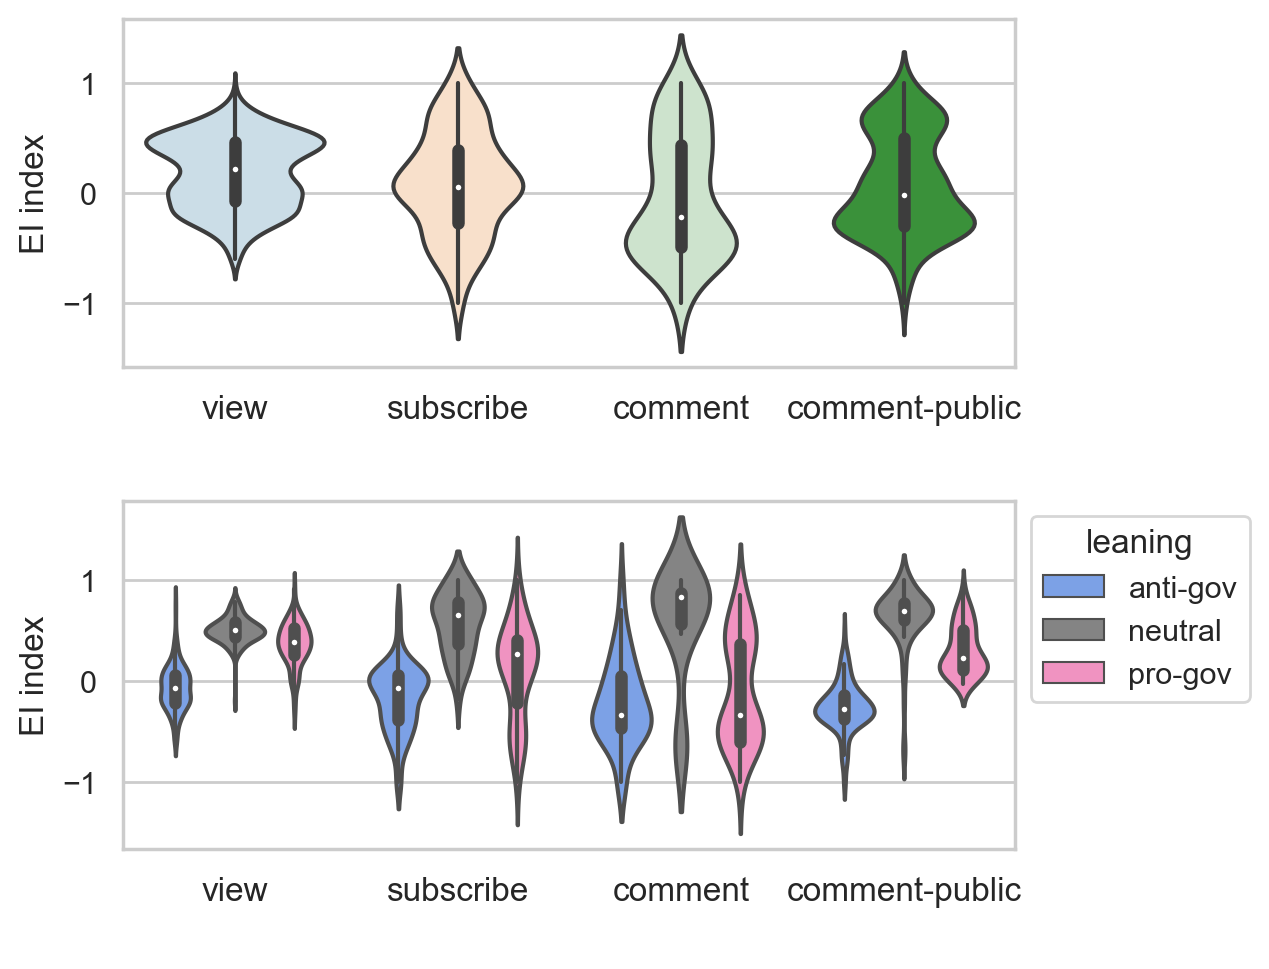

In [24]:
import seaborn as sns
from matplotlib.colors import to_rgba

leaning_map = {-1:"anti-gov", 0:"neutral", 1:"pro-gov"}
sns_data = pd.DataFrame()
for this_folder in engage_type:
    subdf = rate_data[this_folder]
    subdf["engage"] = this_folder
    sns_data = pd.concat([sns_data, subdf])
sns_data["leaning"] = sns_data["leaning"].map(lambda x: leaning_map[x])

# sort the data
sort_dict1 = {"view":0, "subscribe":1, "comment":2, "comment-public":3}
sort_dict2 = {"anti-gov":0, "neutral":1, "pro-gov":2}
sns_data = sns_data.sort_values(by=["leaning"], key=lambda x: x.map(sort_dict2))
sns_data = sns_data.sort_values(by=["engage"], key=lambda x: x.map(sort_dict1))

colors1 = ["#C6DEEC", "#FFDFC3", "#CAE7C9", "#2BA02C"]
colors2 = ["#6B9CF7", "#848484", "#FF84C1"]

fig,ax = plt.subplots(figsize=(6.5,5), nrows=2)
sns.set(style="whitegrid")
sns.violinplot(x="engage", y="rate", data = sns_data, palette=colors1, ax=ax[0])
# sns.boxplot(x="engage", y="rate", data=sns_data, palette=colors1, ax=ax[0])
vp = sns.violinplot(x="engage", y="rate", data = sns_data, hue="leaning", palette=colors2, ax=ax[1], alpha=.4)
    
for i in [0,1]:
    ax[i].set_xlabel(" ")
    ax[i].set_xticks(range(4), engage_type, fontsize=12)
    ax[i].set_ylabel("EI index", fontsize=12)
    # ax[i].set_ylim(-0.25, 1.25)
    # ax[i].set_ylim(-1,1)
sns.move_legend(ax[1], "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(OUTPATH + "ei-homophily-channel-level.pdf", dpi=300, bbox_inches="tight")

In [25]:
for ngg in ["view", "subscribe", "comment", "comment-public"]:
    subdf = sns_data[sns_data["engage"]==ngg]
    print(ngg, len(subdf))

view 545
subscribe 197
comment 105
comment-public 331


In [26]:
COMPARE_PARIS = [
    ("view", "comment"),
    ("subscribe", "comment"),
    ("view", "comment-public"),
    ("subscribe", "comment-public"),
]

In [27]:
# compare the distribution
from scipy.stats import entropy, ks_2samp, mannwhitneyu
from src.utils.functions import compare_distribution_with_sig, compare_distribution_with_sig_weighted

for g1, g2 in COMPARE_PARIS:
    subdf1 = sns_data[sns_data["engage"]==g1]
    subdf2 = sns_data[sns_data["engage"]==g2]
    p1, p2 = compare_distribution_with_sig(
        sample1=subdf1["rate"].tolist(), 
        sample2=subdf2["rate"].tolist(), 
        bruns=1000,
        test_func=ks_2samp, 
        sample_size=min(len(subdf1), len(subdf2)))
    print("p1 =", p1, "\tp2 =", p2, "\n")   


N1 = 105 	N2 = 105
p1 = 0.0 	p2 = 0.0 

N1 = 105 	N2 = 105
p1 = 0.0 	p2 = 0.0 

N1 = 331 	N2 = 331
p1 = 0.0 	p2 = 0.0 

N1 = 197 	N2 = 197
p1 = 0.0 	p2 = 0.0 



In [28]:
def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

def compute_assortativity(g):
    node_attrs = nx.get_node_attributes(g, "leaning")
    edge_wghts = nx.get_edge_attributes(g, "weight")
    x = []
    y = []
    w = []
    for n1,n2 in g.edges():
        x.append(node_attrs[n1])
        y.append(node_attrs[n2])
        w.append(edge_wghts[(n1, n2)])
    c = corr(np.array(x), np.array(y), np.array(w))
    return c

def node_counter(g):
    node_attrs = nx.get_node_attributes(g, "leaning")
    counter = {
        1:0,
        0:0,
        -1:0
    }
    for _,a in node_attrs.items():
        counter[a] += 1
    return counter

def edge_type_counter(g, weighted=False):
    counter = {
        (1,1):0,
        (0,0):0,
        (-1,-1):0,
        (1,0):0,
        (1,-1):0,
        (0,-1):0,
    }
    node_attrs = nx.get_node_attributes(g, "leaning")
    edge_wghts = nx.get_edge_attributes(g, "weight")
    for n1,n2 in g.edges():
        a1 = node_attrs[n1]
        a2 = node_attrs[n2]
        w = edge_wghts[(n1, n2)]
        if weighted:
            try:
                counter[(a1,a2)] += w
            except:
                counter[(a2,a1)] += w
        else:
            try:
                counter[(a1,a2)] += 1
            except:
                counter[(a2,a1)] += 1
    return counter

In [29]:
# node_df = pd.read_csv(OUTPATH + f"view/projnet_channel_id_respondent_id_density0_NODE.csv")
# edge_df = pd.read_csv(OUTPATH + f"view/projnet_channel_id_respondent_id_density0_EDGE.csv")

node_df = pd.read_csv(OUTPATH + f"comment-public/projnet_channel_id_author_name_density0_NODE.csv")
edge_df = pd.read_csv(OUTPATH + f"comment-public/projnet_channel_id_author_name_density0_EDGE.csv")
edge_df = edge_df[edge_df["weight"]>0]

g = read_network(node_df, edge_df, add_node_attrs=True, add_edge_attrs=True)
node_attrs = nx.get_node_attributes(g, "leaning")
edge_wghts = nx.get_edge_attributes(g, "weight")

Graph with 333 nodes and 29300 edges


In [30]:
# node_counter(g)
# edge_type_counter(g)
edge_type_counter(g, weighted=True)

{(1, 1): 75.61655410836772,
 (0, 0): 14.307790476652494,
 (-1, -1): 224.6558997958566,
 (1, 0): 55.20081263978763,
 (1, -1): 174.25438863148503,
 (0, -1): 97.34454682061569}

In [31]:
rate_data = {}
for i,this_folder in enumerate(engage_type):
    bp_data_dict[this_folder] = []
    try:
        node_df = pd.read_csv(OUTPATH + f"{this_folder}/projnet_channel_id_respondent_id_density0_NODE.csv")
        edge_df = pd.read_csv(OUTPATH + f"{this_folder}/projnet_channel_id_respondent_id_density0_EDGE.csv")
    except:
        node_df = pd.read_csv(OUTPATH + f"{this_folder}/projnet_channel_id_author_name_density0_NODE.csv")
        edge_df = pd.read_csv(OUTPATH + f"{this_folder}/projnet_channel_id_author_name_density0_EDGE.csv")

    edge_df = edge_df[edge_df["weight"]>0]
    g = read_network(node_df, edge_df, add_node_attrs=True, add_edge_attrs=True)
    c = compute_assortativity(g)
    print(this_folder)
    print("assortativity score =", c, "'")

Graph with 545 nodes and 76244 edges
view
assortativity score = 0.08331202091849188 '
Graph with 210 nodes and 4814 edges
subscribe
assortativity score = 0.1288725430472519 '
Graph with 108 nodes and 1355 edges
comment
assortativity score = 0.31535726022015675 '
Graph with 333 nodes and 29300 edges
comment-public
assortativity score = 0.16058377650877897 '


In [32]:
# compare with boostrapped sample 
rate_data = {}
nruns = 200
for i,this_folder in enumerate(engage_type):
    print(this_folder)
    try:
        node_df = pd.read_csv(OUTPATH + f"{this_folder}/projnet_channel_id_respondent_id_density0_NODE.csv")
        edge_df = pd.read_csv(OUTPATH + f"{this_folder}/projnet_channel_id_respondent_id_density0_EDGE.csv")
    except:
        node_df = pd.read_csv(OUTPATH + f"{this_folder}/projnet_channel_id_author_name_density0_NODE.csv")
        edge_df = pd.read_csv(OUTPATH + f"{this_folder}/projnet_channel_id_author_name_density0_EDGE.csv")

    edge_df = edge_df[edge_df["weight"]>0]
    if this_folder == "comment-public":
        cs = []
        for r in range(nruns):
            g = read_network(node_df, edge_df, n_sample_nodes=108, add_node_attrs=True, add_edge_attrs=True, print_info=False)
            cs.append(compute_assortativity(g))
        rate_data[this_folder] = cs 
    else:
        g = read_network(node_df, edge_df, add_node_attrs=True, add_edge_attrs=True, print_info=False)
        c = compute_assortativity(g)
        rate_data[this_folder] = c 
    # print("assortativity score =", c)


view
subscribe
comment
comment-public


In [34]:
np.mean(rate_data["comment-public"])

0.1478643124602603

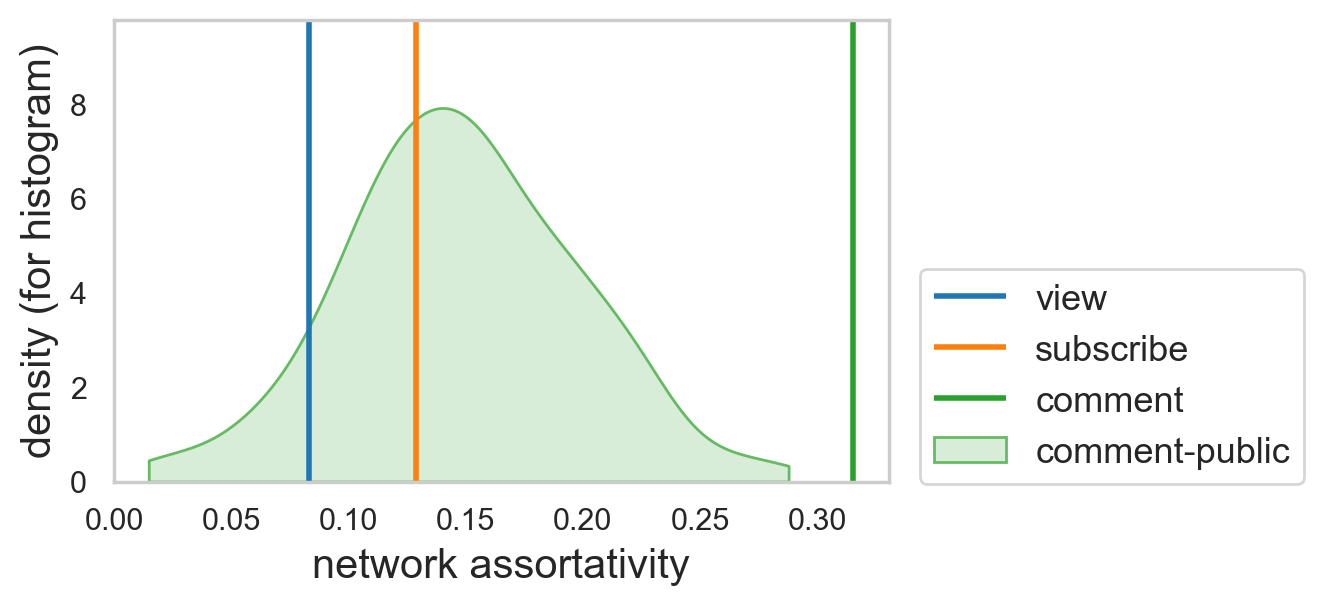

In [37]:
fig,ax = plt.subplots(figsize=(5,3))
sns.set(style="whitegrid")
sns.set_style("whitegrid", {"axes.grid":False})
ax.vlines(x=rate_data["view"], ymin=0, ymax=10, linewidth=2, color="#1F77B4", label="view")
ax.vlines(x=rate_data["subscribe"], ymin=0, ymax=10, linewidth=2, color="#FF7F0D", label="subscribe")
ax.vlines(x=rate_data["comment"], ymin=0, ymax=10, linewidth=2, color="#2BA02C", label="comment")
sns.kdeplot(rate_data["comment-public"], cut=0, fill=True, color="#67BA64", label="comment-public")
ax.set_ylim(0,9.8)
ax.legend(bbox_to_anchor=(1.56,0.5), fontsize=13)
ax.set_xlabel("network assortativity", fontsize=15)
ax.set_ylabel("density (for histogram)", fontsize=15)
# plt.tight_layout()
plt.savefig(OUTPATH + "assortativity-with-resample-channel-level.pdf", dpi=300, bbox_inches="tight")

In [20]:
# colors2 = ["#6B9CF7", "#848484", "#FF84C1"]
# fig,ax = plt.subplots(figsize=(16,4), ncols=4, sharey=True)
# leanings = [-1, 0, 1]
# leaning_labs = ["anti-gov", "neutral", "pro-gov"]
# for i,form in enumerate(engage_type):
#     this_df = rate_data[form]
#     for c,lean,lab in zip(colors2, leanings, leaning_labs):
#         this_subdf = this_df[this_df["leaning"]==lean]
#         ax[i].scatter(this_subdf["strength"], this_subdf["rate"], c=c, label=lab)
#     ax[i].set_title(form, fontsize=15)
# plt.tight_layout()